Generative and DL techniques on small metabolic engineering datasets

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "vscode"


df = pd.read_csv('./data/carotenoid_production.csv')
print(f' * Dataset shape: {df.shape} *')
df.head(3)

 * Dataset shape: (168, 9) *


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.862946,0.987876,0.892209,0.909210,0.848096,0.840536,0.829163,0.753874,3.739360
1,0.783979,1.001960,0.978865,0.916151,0.718987,0.827099,0.960778,0.770533,2.448719
2,0.870862,0.796111,1.096750,0.919447,0.770546,0.879257,0.956943,0.909107,2.454255


In [71]:
X = df.drop(columns=['prod']).values
y = df['prod'].values

Autoencoder Architecture

In [10]:
latent_dim = 2
dim = len(X[0])

input_lyr = Input(shape=(dim,))
encoded = Dense(15, name='enc1', activation='relu')(input_lyr)
encoded = BatchNormalization()(encoded)
encoded = Dropout(rate=0.1)(encoded)
encoded = Dense(15, name='enc2',activation='relu')(encoded)
encoded = Dense(13, name='enc3',activation='relu')(encoded)
encoded = Dense(13, name='enc4',activation='relu')(encoded)
encoded = Dense(latent_dim, name='enc5',activation='relu')(encoded)

decoded = Dense(latent_dim, name='dec1',activation='relu')(encoded)
decoded = Dense(13, name='dec2',activation='relu')(decoded)
decoded = Dense(13, name='dec3',activation='relu')(decoded)
decoded = Dense(15, name='dec4',activation='relu')(decoded)
decoded = Dropout(rate=0.1)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(15, name='dec5',activation='relu')(decoded)
decoded = Dense(dim, name='dec6',activation='relu')(decoded)
AE = Model(input_lyr, decoded)
Encoder = Model(input_lyr,encoded)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
AE.compile(optimizer=optimizer, loss='mean_squared_error')
history = AE.fit(X, X, epochs=800, batch_size=32, shuffle=True, verbose=True)

Epoch 1/800
6/6 [==============================] - 2s 5ms/step - loss: 24.0513
Epoch 2/800
6/6 [==============================] - 0s 5ms/step - loss: 23.6226
Epoch 3/800
6/6 [==============================] - 0s 4ms/step - loss: 23.0960
Epoch 4/800
6/6 [==============================] - 0s 4ms/step - loss: 22.5132
Epoch 5/800
6/6 [==============================] - 0s 4ms/step - loss: 22.2575
Epoch 6/800
6/6 [==============================] - 0s 5ms/step - loss: 21.7715
Epoch 7/800
6/6 [==============================] - 0s 4ms/step - loss: 21.2536
Epoch 8/800
6/6 [==============================] - 0s 4ms/step - loss: 20.7850
Epoch 9/800
6/6 [==============================] - 0s 4ms/step - loss: 20.3579
Epoch 10/800
6/6 [==============================] - 0s 4ms/step - loss: 20.0016
Epoch 11/800
6/6 [==============================] - 0s 5ms/step - loss: 19.6054
Epoch 12/800
6/6 [==============================] - 0s 5ms/step - loss: 19.3625
Epoch 13/800
6/6 [==============================]

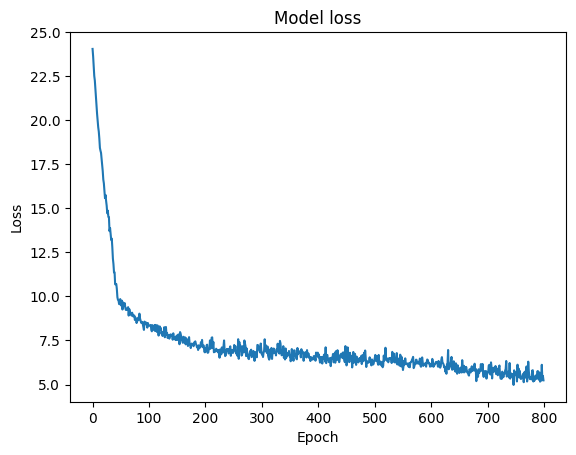

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 3ms/step


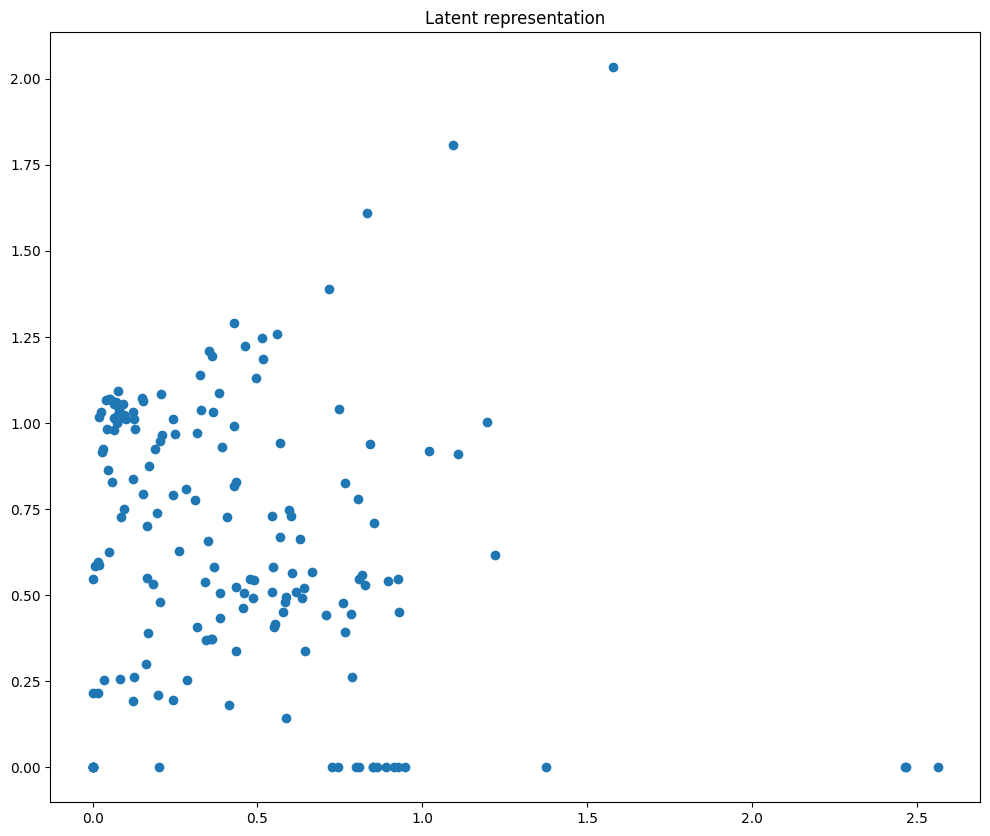

In [12]:
# Get the latent representation of the input
encoded_X = Encoder.predict(X)

# Plot the latent representation
plt.figure(figsize=(12, 10))
plt.scatter(encoded_X[:, 0], encoded_X[:, 1])
plt.title('Latent representation')
plt.show()

In [14]:
fake_data = AE.predict(X)

6/6 [==============================] - 0s 3ms/step


### Statistical Validation

In [29]:
X_df = pd.DataFrame(X, columns=df.columns[:-1])
fake_data_df = pd.DataFrame(fake_data, columns=df.columns[:-1])

In [46]:
from sdv.metadata import SingleTableMetadata
from sdmetrics.reports.single_table import DiagnosticReport

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(X_df)

diagnostic = DiagnosticReport()
diagnostic.generate(X_df, fake_data_df, metadata.to_dict())

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 8/8 [00:00<00:00, 1336.03it/s]|
Data Validity Score: 99.78%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 262.72it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.89%



In [72]:
from sdmetrics.reports.single_table import QualityReport

quality_report = QualityReport()
quality_report.generate(X_df, fake_data_df, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 8/8 [00:00<00:00, 890.79it/s]|
Column Shapes Score: 69.64%

(2/2) Evaluating Column Pair Trends: |██████████| 28/28 [00:00<00:00, 167.73it/s]|
Column Pair Trends Score: 87.58%

Overall Score (Average): 78.61%



In [82]:
pp = quality_report.get_visualization('Column Pair Trends')
pio.renderers.default = "vscode"
pp